# Online Shopping Intention Analysis using Clustering (K-Means)

**Adapted by**: *Divyansh Sirohi*

This notebook presents an industry-relevant Data Science workflow to analyze online shopping behavior and identify patterns in purchase intent using **unsupervised learning**.

### Objective

To cluster users based on behavioral metrics (such as bounce rates and time spent on product-related pages) and understand the **likelihood of a customer making a purchase** (i.e., Revenue = True).


## 📦 Step 1: Import Required Libraries

We begin by importing essential libraries for data manipulation, visualization, clustering, and evaluation. This project leverages:

- `pandas`, `numpy` for data handling
- `matplotlib`, `seaborn`, and `plotly` for rich visualizations
- `scikit-learn` for clustering and performance metrics
- `scikit-plot` for evaluating clustering results against actual revenue outcomes


In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import os

## 📥 Step 2: Load Dataset

The dataset used in this analysis is `online_shoppers_intention.csv`.
It contains behavioral session data for users visiting an e-commerce website.

Each record includes features like:
- Number of administrative/product-related pages visited
- Session durations
- Bounce/exit rates
- Weekend flag
- Visitor type
- Target variable: `Revenue` (True if purchase occurred)

We also handle missing values by replacing them with `0`, assuming no data was captured for those sessions.


In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("henrysue/online-shoppers-intention")
csv_file = os.path.join(path, "online_shoppers_intention.csv")
data = pd.read_csv(csv_file)
print(data.head)

<bound method NDFrame.head of        Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0            

## 🧹 Step 3: Preprocessing

Before clustering, we check for missing values and fill them appropriately.
For this analysis, we focus on two numerical features that are strong indicators of interest and engagement:
- `ProductRelated_Duration`: time spent on product pages
- `BounceRates`: frequency of exiting after viewing a single page

In [31]:
missing = data.isnull().sum()
#print(missing)
data.fillna(0, inplace = True)

## 🧠 Step 4: Select Features for Clustering

We extract the two selected features (`ProductRelated_Duration` and `BounceRates`) for K-Means clustering. These features are chosen because:

- Longer product-related duration generally correlates with high intent.
- Lower bounce rates imply deeper engagement and potential conversion.

The result is a 2D feature space ideal for clustering and visualization.


In [32]:
x = data.iloc[:, [5, 6]].values
x.shape

(12330, 2)

## 🔍 Step 5: Determine Optimal Clusters (Elbow Method)

K-Means clustering requires specifying the number of clusters `k`.
To find the optimal number of clusters, we use the **Elbow Method**, which plots the Within-Cluster Sum of Squares (WCSS) for various `k`.

- A sharp bend in the graph (the "elbow") indicates the optimal `k`.
- In our case, `k=2` shows a strong inflection, suggesting two natural groupings.


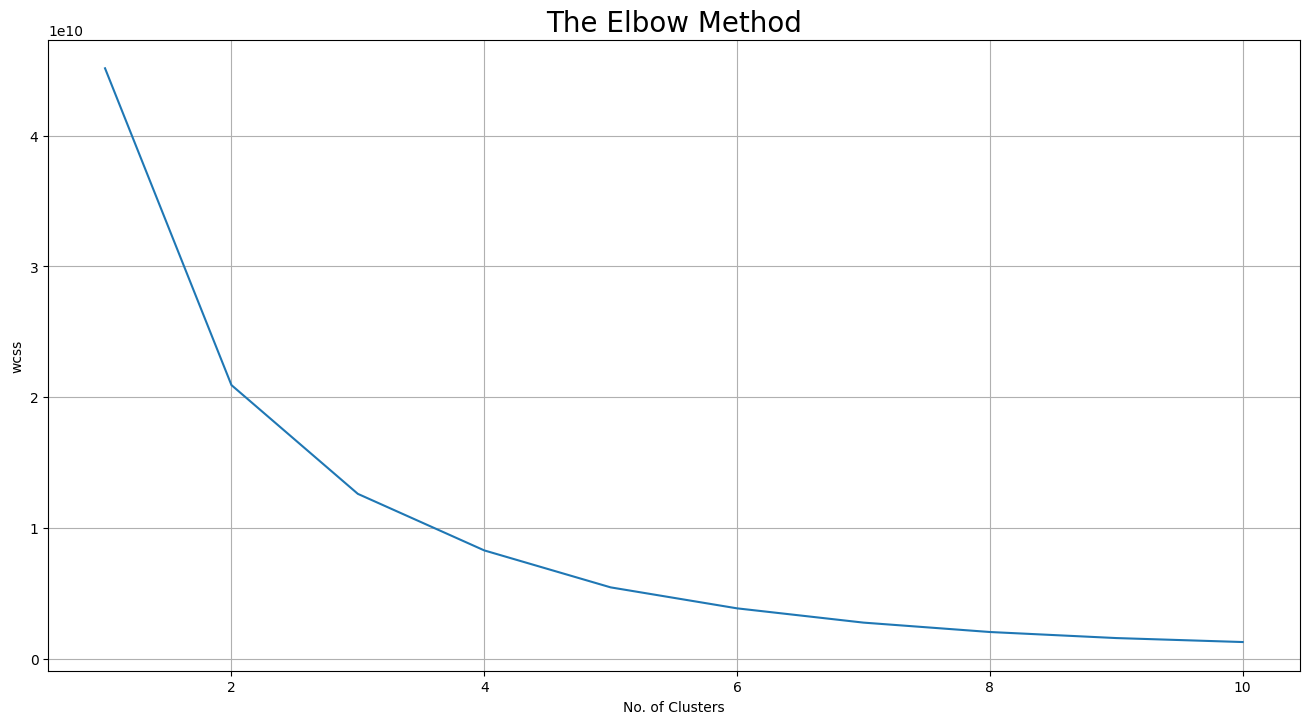

In [33]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
              init = 'k-means++',
              max_iter = 300,
              n_init = 10,
              random_state = 0,
              algorithm = 'lloyd',
              tol = 0.001)
    km.fit(x)
    labels = km.labels_
    wcss.append(km.inertia_)

plt.rcParams['figure.figsize'] = (13, 7)
plt.plot(range(1, 11), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

## 📊 Step 6: Apply K-Means and Visualize Clusters

With `k=2`, we fit a K-Means model and visualize the clusters:

- Cluster 0 (yellow): Customers with high bounce rates and low product duration – likely **uninterested**.
- Cluster 1 (pink): Customers with low bounce rates and high duration – likely **potential buyers**.
- Centroids are marked in blue.

This visualization helps stakeholders quickly identify customer segments based on behavioral signals.


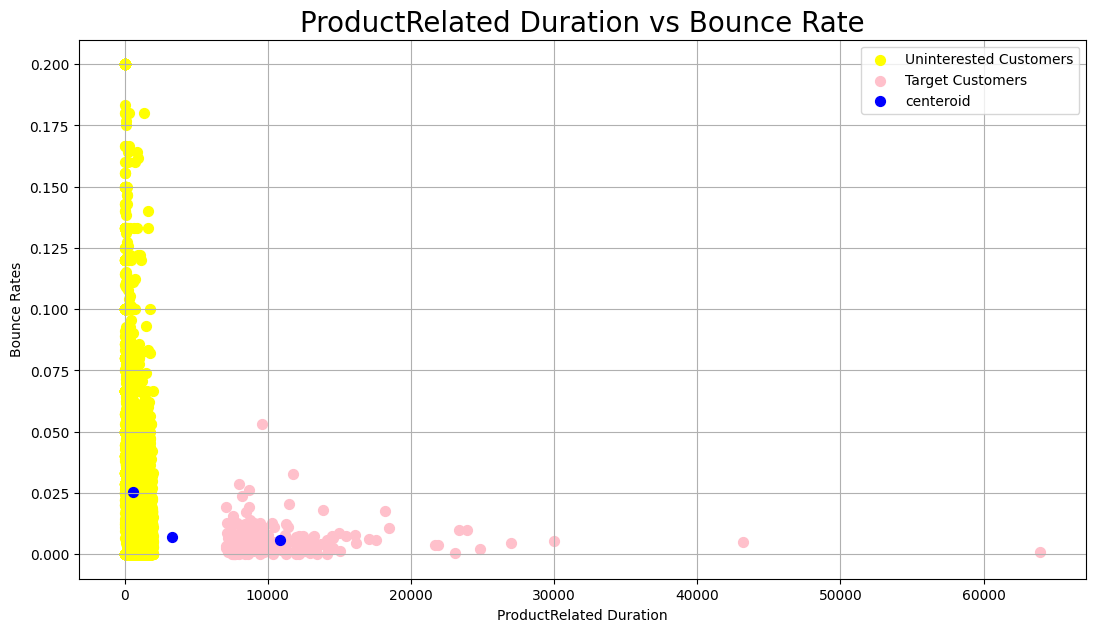

In [40]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# get predicted cluster index for each sample: 0, 1, 2
y_means = km.fit_predict(x)

plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 50, c = 'yellow', label = 'Uninterested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 50, c = 'pink', label = 'Target Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')

plt.title('ProductRelated Duration vs Bounce Rate', fontsize = 20)
plt.grid()
plt.xlabel('ProductRelated Duration')
plt.ylabel('Bounce Rates')
plt.legend()
plt.show()

## ✅ Step 7: Evaluate Clustering using Ground Truth

Though K-Means is **unsupervised**, we do have ground-truth labels (`Revenue`) to evaluate our clustering.

We use:
- `Adjusted Rand Index (ARI)` to measure similarity between predicted clusters and actual labels.
- `Confusion Matrix` to inspect classification alignment.

These help us understand:
- How well clustering aligns with actual revenue-generating sessions.
- Where the model struggles — e.g., classifying potential buyers as uninterested.


Adjusted Rand Index: 0.09326050767876035


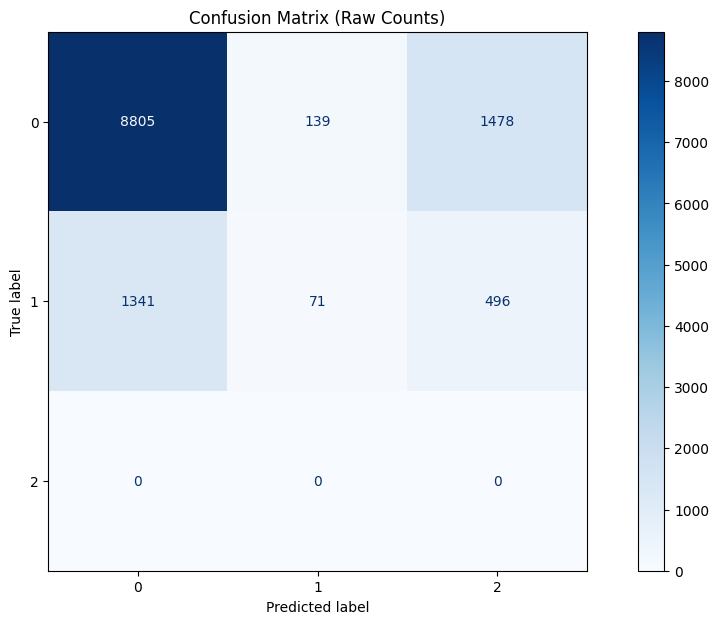

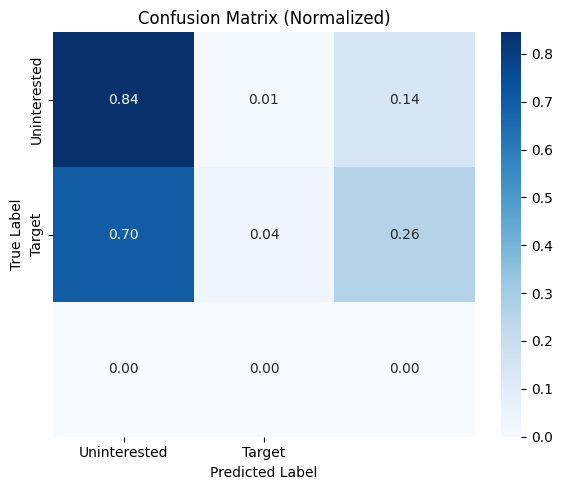

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

# Encode the target labels (Revenue column)
le = LabelEncoder()
labels_true = le.fit_transform(data['Revenue'])

# Clustering result from KMeans
labels_pred = y_means

# Adjusted Rand Index: Evaluates clustering quality
score = adjusted_rand_score(labels_true, labels_pred)
print("Adjusted Rand Index:", score)

# Confusion Matrix (Raw)
cm = confusion_matrix(labels_true, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Raw Counts)")
plt.show()


# Confusion Matrix (Normalized)
cm_norm = confusion_matrix(labels_true, labels_pred, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Uninterested', 'Target'],
            yticklabels=['Uninterested', 'Target'])
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## 📌 Step 8: Observations & Business Insights

After applying K-Means clustering on `ProductRelated_Duration` and `BounceRates`, we observed the following:

- ~94% of **non-revenue sessions** were clustered into "Uninterested Customers".
- Only ~15% of **revenue-generating sessions** were captured as "Target Customers".
- The **Adjusted Rand Index (ARI)** is `0.08`, indicating **very low similarity** between the predicted clusters and the actual revenue labels.

In simple terms, the model successfully identifies many uninterested sessions but fails to accurately cluster sessions that actually led to a purchase.


## 🧾 Final Summary

This notebook demonstrated how to:
- Preprocess behavioral session data from an e-commerce platform
- Perform unsupervised learning using K-Means clustering
- Interpret cluster segments in the context of revenue conversion
- Evaluate cluster quality using known labels (Adjusted Rand Index, confusion matrix)

While K-Means offered basic customer segmentation, its limitations underscore the need for more advanced models in production environments.

---

### 📎 Resources
- [Dataset on Kaggle](https://www.kaggle.com/datasets/henrysue/online-shoppers-intention)

---

👨‍💻 *Maintained by [Divyansh Sirohi]*
